# 4.1. Definitions

In [1]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

## 4.1.2.3. Precision-Recall curve and Average Precision

Building a PR-curve from synthetic data.

AP=0.919


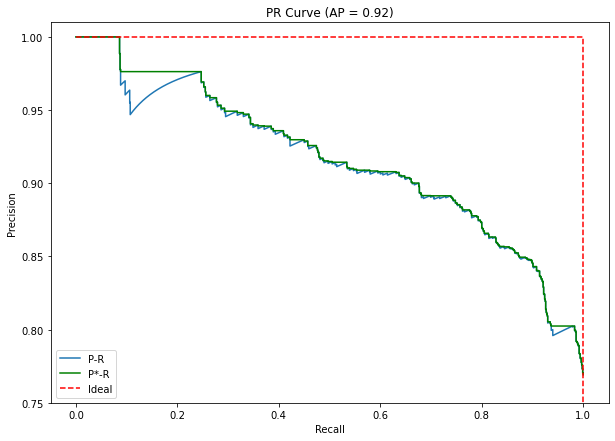

In [2]:
from metrics.detection import average_precision

N_objects = 1000
N_detected = 1300

np.random.seed(10)
gt = np.array([1 for _ in range(N_objects)] + [0 for _ in range(N_detected-N_objects)])
pred_confidence = []
for _ in range(N_objects):
    pred_confidence.append(np.clip(np.random.normal(loc=0.9, scale=0.7), 0, 1))
for _ in range(N_detected-N_objects):
    pred_confidence.append(np.clip(np.random.normal(loc=0.1, scale=0.7), 0, 1))
pred_confidence = np.array(pred_confidence)
    
computed_ap, pr_points = average_precision(gt, pred_confidence)
pr_star = pr_points.copy()
for i in range(pr_star.shape[0]):
    pr_star[i, 0] = pr_points[i:, 0].max()

print(f"AP={computed_ap:.3f}")
plt.figure(figsize=(10,7))
plt.plot(pr_points[:, 1], pr_points[:, 0], label="P-R")
plt.plot(pr_star[:, 1], pr_star[:, 0], 'g-', label="P*-R")
plt.plot([0, 1, 1], [1, 1, 0.75], 'r--', label="Ideal")
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.75, 1.01])
plt.title(f'PR Curve (AP = {computed_ap:.2f})')
plt.legend()
plt.show()

## 4.1.3.3. ROC curve and AUROC

Building a ROC-curve from synthetic data on a 3-classes problem.

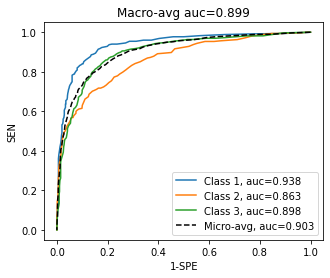

Micro-averaged AUROC=0.903
Macro-averaged AUROC=0.899


In [3]:
from sklearn.datasets import make_classification
from sklearn.svm import SVC
from metrics.classification import get_micro_auroc, get_macro_auroc
from sklearn.metrics import roc_curve, auc

np.random.seed(200)

X,Y = make_classification(n_samples=5000, n_features=16, n_informative=5, n_classes=3, flip_y=0.05, class_sep=0.6)

clf = SVC(probability=True)
clf.fit(X[:4000], Y[:4000])
pred = clf.predict_proba(X[4000:])

pred_label = pred.argmax(axis=1)
true_label = Y[4000:]

def cm(gt, prob, c, t):
    cm = np.zeros((2,2))
    for g,p in zip(gt,prob):
        cm[int(g==c), int(p[c]>=t)] += 1
    return cm

def sen_fpr(cm):
    TP = cm[1,1]
    FP = cm[0,1]
    FN = cm[1,0]
    TN = cm[0,0]
    
    return TP/(TP+FN), TN/(TN+FP)

rocs = {}
for c in range(3):
    rocs[c] = []
    for t in np.arange(0,1.01,0.01):
        rocs[c].append(sen_fpr(cm(true_label, pred, c, t)))
    rocs[c] = np.array(rocs[c])
    
micro_roc = []
for idt,t in enumerate(np.arange(0,1.01,0.01)):
    cm_micro = np.zeros((2,2))
    for c in range(3):
        cm_micro += cm(true_label, pred, c, t)
    micro_roc.append(sen_fpr(cm_micro))
micro_roc = np.array(micro_roc)

aucs = [auc(1-rocs[c][:,1], rocs[c][:,0]) for c in range(3)]

plt.figure(figsize=(5,4))
for c in range(3):
    plt.plot(1-rocs[c][:,1], rocs[c][:,0], '-', label=f'Class {c+1}, auc={auc(1-rocs[c][:,1], rocs[c][:,0]):.3f}')
plt.plot(1-micro_roc[:,1], micro_roc[:,0], 'k--', label=f'Micro-avg, auc={auc(1-micro_roc[:,1], micro_roc[:,0]):.3f}')
plt.xlabel('1-SPE')
plt.ylabel('SEN')
plt.legend()
plt.title(f'Macro-avg auc={sum(aucs)/len(aucs):.3f}')
plt.show()

print(f"Micro-averaged AUROC={get_micro_auroc(true_label, pred):.3f}")
print(f"Macro-averaged AUROC={get_macro_auroc(true_label, pred):.3f}")